In [1]:
from Eof_functions import *

path = 'C:\\Users\\ratynski\\Documents\\Python_Projects\\stratocu_waves-main\\DATA\\2022_09_06\\'
os.chdir(path)
files = glob.glob('*.png')

#for each image, create a frame_letter variable that will be used to store the imread image

frame_a = tools.imread(path + files[0])
frame_b = tools.imread(path + files[1])
frame_c = tools.imread(path + files[2])
frame_d = tools.imread(path + files[3])
frame_e = tools.imread(path + files[4])
frame_f = tools.imread(path + files[5])
frame_g = tools.imread(path + files[6])
frame_h = tools.imread(path + files[7])
frame_i = tools.imread(path + files[8])
frame_j = tools.imread(path + files[9])

frames = np.array([frame_a, frame_b, frame_c, frame_d, frame_e, frame_f, frame_g, frame_h, frame_i, frame_j])

In [3]:
# Open the data, window it and perform the 3D FFT

data = frames
data_shape = data.shape
data_w = np.copy(data)
for dim in range(1, 3):  # This changes from range(3) to range(1, 3)
    border_size = int(data_shape[dim] * 0.1)  # 10% of the dimension size
    if border_size < 1:
        border_size = 1  # Ensure at least one point gets the window applied
    
    full_window = np.hanning(2 * border_size)  # Full window for both sides
    window = np.ones(data_shape[dim])  # Create a window array full of ones
    window[:border_size] = full_window[:border_size]
    window[-border_size:] = full_window[border_size:]

    # Reshape the window to match the data dimension
    if dim == 1:
        window = window[np.newaxis, :, np.newaxis]
    elif dim == 2:
        window = window[np.newaxis, np.newaxis, :]

    # Multiply the data with the window
    data_w *= window

# Perform 3D FFT
fft_data = np.fft.fftn(data_w)
fft_data = np.fft.fftshift(fft_data)

# Calculate kl unitlessly for each pixel
k = np.fft.fftshift(np.fft.fftfreq(data_shape[2], d=1/data_shape[2])) 
l = np.fft.fftshift(np.fft.fftfreq(data_shape[1], d=1/data_shape[1]))
k, l = np.meshgrid(k, l)

k = k/(data_shape[2])
l = l/(data_shape[1])


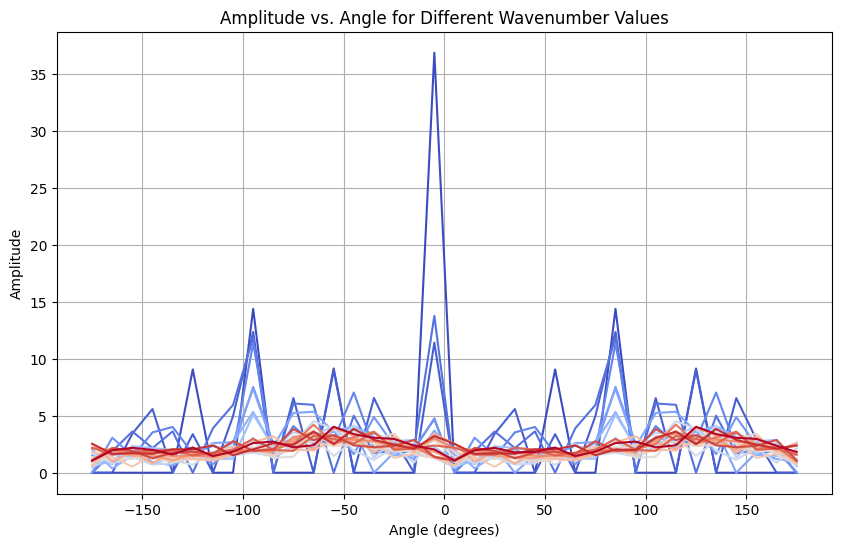

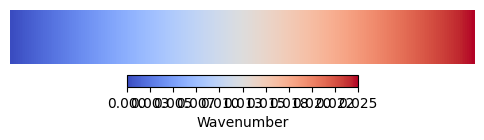

In [4]:
kl_cutoff_inf, kl_cutoff_sup = 0, 0.025

radius = np.sqrt(k**2 + l**2)
theta = np.arctan2(l, k)
amplitude = np.abs(fft_data)

# Create theta bins
num_bins = 36  # 10 degrees each bin 
theta_bins = np.linspace(np.min(theta), np.max(theta), num_bins + 1)

# Define wavenumber range and step
min_wavenumber = kl_cutoff_inf
max_wavenumber = kl_cutoff_sup
wavenumber_step = 0.001
wavenumber_values = np.arange(min_wavenumber + wavenumber_step, max_wavenumber, wavenumber_step)
    
# Create a colormap
cmap = plt.get_cmap('coolwarm')
colors = cmap(np.linspace(0, 1, len(wavenumber_values)))

plt.figure(figsize=(10, 6))
for i, wavenumber in enumerate(wavenumber_values):
    in_k_range = (radius > (wavenumber - wavenumber_step/2)) & (radius < (wavenumber + wavenumber_step/2))
    
    # Calculate the mean amplitude in each theta bin for the current wavenumber range
    mean_amplitude = np.zeros(num_bins)
    for j in range(num_bins):
        in_bin = (theta >= theta_bins[j]) & (theta < theta_bins[j + 1])
        mean_amplitude[j] = np.mean(amplitude * in_k_range * in_bin)
    
    plt.plot(theta_bins[:-1] * 180 / np.pi + 360 / num_bins / 2, mean_amplitude, color=colors[i])

plt.title('Amplitude vs. Angle for Different Wavenumber Values')
plt.xlabel('Angle (degrees)')
plt.ylabel('Amplitude')
plt.grid(True)

# Create custom color legend
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(figsize=(6, 1))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

ticks = np.linspace(0, 1, 11)
tick_labels = np.linspace(min_wavenumber, max_wavenumber, 11)
tick_labels = [f"{tick:.3f}" for tick in tick_labels]

cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, orientation='horizontal', ticks=ticks)
cbar.ax.set_xticklabels(tick_labels)
cbar.set_label('Wavenumber')

plt.show()


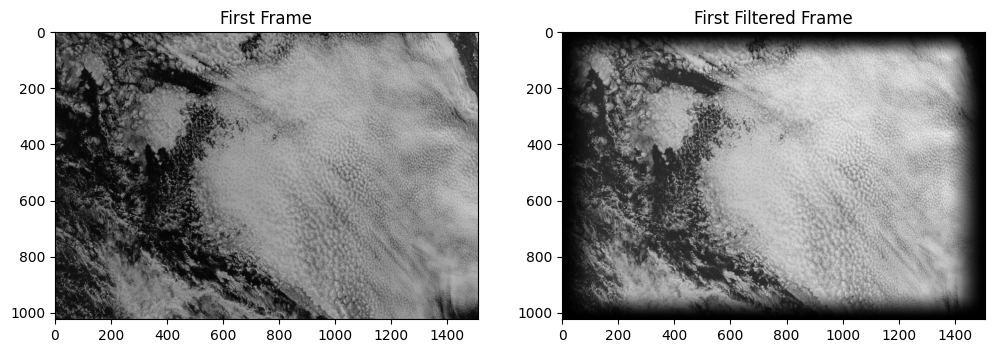

In [7]:
# Calculate total wavenumber array
kl = np.sqrt(k**2 + l**2)

# Frequency components as unitless (normalized index positions)
f = np.fft.fftfreq(data_shape[0])
f = np.fft.fftshift(f)

# Calculate unitless phase speed
kl[kl == 0] = np.inf  # Avoid division by zero
c = np.abs(f[:, np.newaxis, np.newaxis]) / kl  # c is unitless
kl[kl == np.inf] = 0

kl = np.repeat(kl[np.newaxis, :, :], data_shape[0], axis=0)
f = np.repeat(f[:, np.newaxis], data_shape[1], axis=1)
f = np.repeat(f[:, :, np.newaxis], data_shape[2], axis=2)


# Inverse FFT and return
fft_data = np.fft.ifftshift(fft_data)
filtered_data = np.fft.ifftn(fft_data)
filtered_data = np.real(filtered_data)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(data[0], cmap='gray')
axs[0].set_title("First Frame")
axs[1].imshow(filtered_data[0], cmap='gray')
axs[1].set_title("First Filtered Frame")
plt.show()



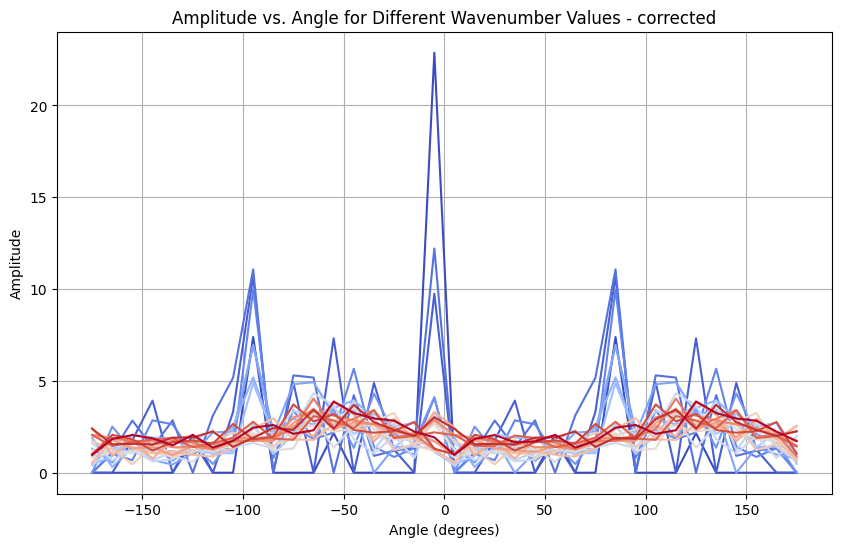

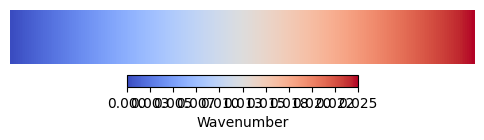

In [10]:
plt.figure(figsize=(10, 6))
for i, wavenumber in enumerate(wavenumber_values):
    in_k_range = (radius > (wavenumber - wavenumber_step/2)) & (radius < (wavenumber + wavenumber_step/2))

    if np.any(in_k_range):
        min_amplitude = np.min(amplitude[:, in_k_range], axis=1, keepdims=True)
        amplitude[:, in_k_range] -= min_amplitude

    # Calculate the mean amplitude in each theta bin for the current wavenumber range
    mean_amplitude = np.zeros(num_bins)
    for j in range(num_bins):
        in_bin = (theta >= theta_bins[j]) & (theta < theta_bins[j + 1])
        mean_amplitude[j] = np.mean(amplitude * in_k_range * in_bin)



    plt.plot(theta_bins[:-1] * 180 / np.pi + 360 / num_bins / 2, mean_amplitude, color=colors[i])

plt.title('Amplitude vs. Angle for Different Wavenumber Values - corrected')
plt.xlabel('Angle (degrees)')
plt.ylabel('Amplitude')
plt.grid(True)

# Create custom color legend
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(figsize=(6, 1))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

ticks = np.linspace(0, 1, 11)
tick_labels = np.linspace(min_wavenumber, max_wavenumber, 11)
tick_labels = [f"{tick:.3f}" for tick in tick_labels]

cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, orientation='horizontal', ticks=ticks)
cbar.ax.set_xticklabels(tick_labels)
cbar.set_label('Wavenumber')

plt.show()

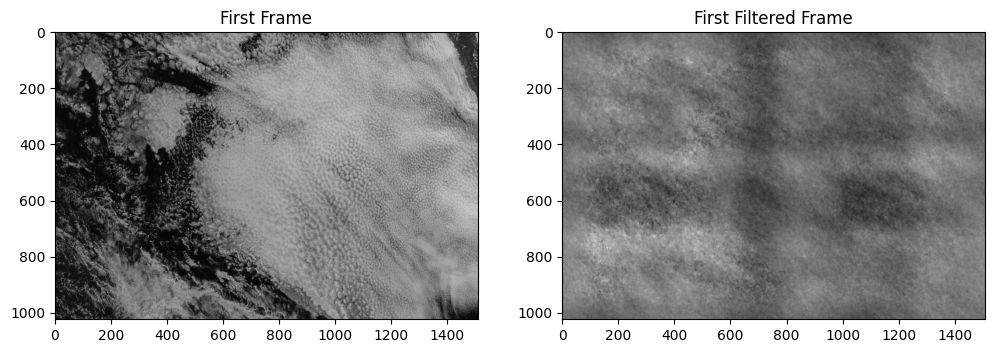

In [11]:
# Reconstruct FFT data with corrected amplitude and original phase
phase = np.angle(fft_data)
fft_data_corrected = amplitude * np.exp(1j * phase)

# Inverse FFT and return
fft_data_corrected = np.fft.ifftshift(fft_data_corrected)
filtered_data = np.fft.ifftn(fft_data_corrected)
filtered_data = np.real(filtered_data)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(data[0], cmap='gray')
axs[0].set_title("First Frame")
axs[1].imshow(filtered_data[0], cmap='gray')
axs[1].set_title("First Filtered Frame")
plt.show()